In [2]:
import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from pandas_datareader._utils import RemoteDataError
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [3]:
def get_stock_dat(stock,start_date,end_date):
  prices = web.DataReader(stock, 'yahoo', start=start_date, end=end_date).Close
  return prices


In [35]:
start_date = datetime(2018,9,1)
end_date = datetime(2020,10,6)
stock = 'RUN'
data = get_stock_dat(stock,start_date,end_date)

In [36]:
df = data.reset_index()['Close']

<AxesSubplot:>

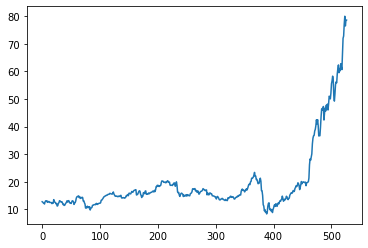

In [37]:
df.plot()

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))
df[1:5]

array([[0.0597682 ],
       [0.05543919],
       [0.05446167],
       [0.05013266]])

In [39]:
scaler.inverse_transform(df)[1:5]

array([[12.64000034],
       [12.32999992],
       [12.26000023],
       [11.94999981]])

In [40]:
training_size = int(len(df)*0.65)
test_size = len(df) - training_size
training_data,test_data = df[0:training_size,:],df[training_size:len(df),:1]

In [41]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)


In [42]:
time_step = 50
X_train,Y_train = create_dataset(training_data,time_step)
X_test,Y_test = create_dataset(test_data,time_step)


In [43]:
X_train.shape,X_test.shape

((291, 50), (134, 50))

In [44]:
Y_train.shape,Y_test.shape

((291,), (134,))

In [45]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [47]:
model = Sequential()
model.add(LSTM(50,return_sequences= True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences = True,))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error',optimizer = 'adam')

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
5/5 [==============================] - 1s 216ms/step - loss: 0.0049 - val_loss: 0.0525
Epoch 2/100
5/5 [==============================] - 0s 42ms/step - loss: 0.0015 - val_loss: 0.0774
Epoch 3/100
5/5 [==============================] - 0s 43ms/step - loss: 8.9894e-04 - val_loss: 0.0903
Epoch 4/100
5/5 [==============================] - 0s 42ms/step - loss: 7.6569e-04 - val_loss: 0.0730
Epoch 5/100
5/5 [==============================] - 0s 42ms/step - loss: 6.8230e-04 - val_loss: 0.0660
Epoch 6/100
5/5 [==============================] - 0s 41ms/step - loss: 6.0355e-04 - val_loss: 0.0748
Epoch 7/100
5/5 [==============================] - 0s 40ms/step - loss: 5.9345e-04 - val_loss: 0.0717
Epoch 8/100
5/5 [==============================] - 0s 43ms/step - loss: 5.0988e-04 - val_loss: 0.0592
Epoch 9/100
5/5 [==============================] - 0s 40ms/step - loss: 5.0269e-04 - val_loss: 0.0549
Epoch 10/100
5/5 [==============================] - 0s 41ms/step - loss: 4.4397e-04 - val

In [50]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


In [51]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [52]:
# root mean squared error
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

15.38748641882168

In [53]:
math.sqrt(mean_squared_error(Y_test,test_predict))

35.05548861991258

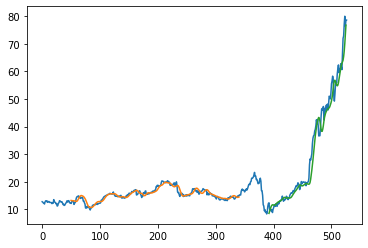

In [54]:
### Plotting 
# shift train predictions for plotting
look_back= time_step
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [55]:
n = len(test_data)-100


In [56]:
x_input=test_data[n:].reshape(1,-1)
x_input.shape

(1, 100)

In [57]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [58]:
#


In [59]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[1.03433]
101
1 day input [0.09467952 0.0998464  0.1054322  0.10766653 0.10473397 0.11129731
 0.11855887 0.11269376 0.11646419 0.13000978 0.13378021 0.1429968
 0.13859796 0.1442536  0.15751989 0.1531909  0.14327609 0.1229577
 0.13364056 0.14844295 0.16394359 0.15263233 0.15975421 0.16108086
 0.16212819 0.15891635 0.15863705 0.16087138 0.1427175  0.15584416
 0.15863705 0.16031281 0.16254713 0.1812596  0.24870828 0.2780338
 0.2718894  0.28662198 0.30344924 0.35497833 0.38339615 0.39505657
 0.3972909  0.4194945  0.4275939  0.44672529 0.47619046 0.45566264
 0.47674905 0.4482614  0.39442814 0.39533582 0.39561511 0.43876551
 0.49127218 0.53121074 0.53302609 0.52562491 0.54349949 0.47493365
 0.51082249 0.53581901 0.52045804 0.54978354 0.52995393 0.55550899
 0.52555507 0.5567658  0.59544755 0.59251502 0.58190194 0.61080852
 0.65842756 0.67302052 0.69696969 0.68028208 0.59754226 0.57066049
 0.60787598 0.65465718 0.66792345 0.66359448 0.70856022 0.73523247
 0.7536657  0.71442536 0.73313783 0.723

In [60]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [61]:
m = len(df) - 100

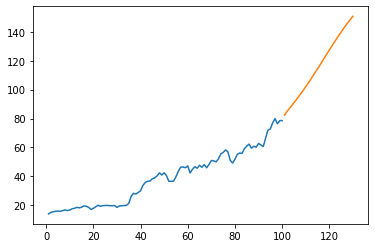

In [62]:
plt.plot(day_new,scaler.inverse_transform(df[m:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

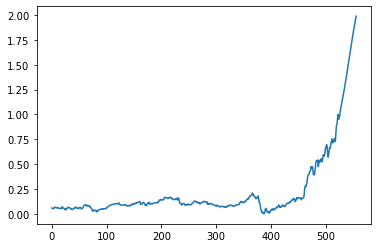

In [63]:
df3=df.tolist()
df3.extend(lst_output)
plt.plot(df3[1:])

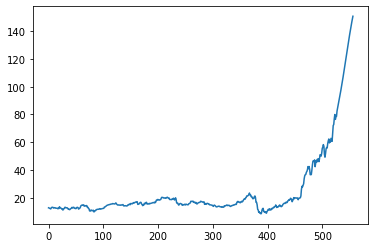

In [64]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

